In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report,f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

In [2]:
try:
   df = pd.read_csv('koi_data.csv')
except:
   print("Falha ao abrir o banco de dados!")
else:
   print("Banco de dados aberto!")


Banco de dados aberto!


In [3]:
X = df.iloc[:, 2:].values  # Todas as colunas exceto a primeira (KOI ID) e a segunda (label)
Y = df.iloc[:, 1].values   # Segunda coluna (label) Koi Disposition, Confirmed, False Positive
all_metrics=[]
all_confusion_matrix=[]
num_classes = len(np.unique(Y))  # Calcula o número de classes com base nos dados

In [4]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machines': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Tree Boosting': GradientBoostingClassifier(),
    # 'Multi-layer Perceptron': definida dentro do escopo da funcao
}


In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#Aqui, shuffle=True embaralha os dados antes de dividí-los, e random_state=42 garante que os resultados sejam reprodutíveis.

In [6]:
def evaluate_model(model, X, Y, kf,model_name):
    y_true = []
    y_pred = []
    accuracies=[]
    precisions = []
    recalls = []
    f1_scores = []
    cm=np.zeros((num_classes, num_classes))
    for train_index, test_index in kf.split(X):
       
         X_train, X_test = X[train_index], X[test_index]
         Y_train, Y_test = Y[train_index], Y[test_index]
        
         pipeline = make_pipeline(StandardScaler(), model)
         pipeline.fit(X_train, Y_train)
         
         Y_pred = pipeline.predict(X_test)
         y_true.extend(Y_test)# LENTO!
         y_pred.extend(Y_pred)#LENTO!
        
         accuracy = accuracy_score(Y_test, Y_pred)
         aux_cm=confusion_matrix(Y_test,Y_pred)
         cm+=aux_cm
  
         precision = precision_score(Y_test, Y_pred, average='weighted')
         recall = recall_score(Y_test, Y_pred, average='weighted')
         f1 = f1_score(Y_test, Y_pred, average='weighted')
        
         accuracies.append(round(accuracy, 4))
         precisions.append(round(precision, 4))
         recalls.append(round(recall, 4))
         f1_scores.append(round(f1, 4))
    

    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    all_confusion_matrix.append(cm)
    all_metrics.append((str(model_name), round(mean_accuracy, 4), round(mean_precision, 4), round(mean_recall, 4), round(mean_f1, 4)))


In [7]:
def naive_bayes_experiment(X, Y, kf):
    model = GaussianNB()
    model_name="Naive Bayes"
    evaluate_model(model, X, Y, kf,model_name)  # Avalia o modelo com matriz de confusão e relatório de métricas
    #pipeline = make_pipeline(StandardScaler(), model)
    #scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
    mean_accuracy = all_metrics[-1][1]
    #print(f'Naive Bayes: Acurácia média = {mean_accuracy:.4f}, Desvio padrão = {scores.std():.4f}')
    return mean_accuracy

In [8]:
def decision_tree_experiment(X, Y, kf):
    depths = [None, 5, 10, 15, 20]
    dte_accuracies = []
    model_name="Decision Tree with Depth= "
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(depth))  # Avalia o modelo com matriz de confusão e relatório de métricas
        dte_accuracies.append(all_metrics[-1][1])
       
    plt.plot(depths, dte_accuracies, marker='o')
    plt.xlabel('Profundidade Máxima')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto da Profundidade Máxima na Acurácia do Decision Tree')
    plt.grid(True)
    plt.show()

In [9]:
def svm_experiment(X, Y, kf):
    kernels = ['linear', 'rbf']
    svm_accuracies = []
    model_name="SVM with Kernel "
    for kernel in kernels:
        model = SVC(kernel=kernel, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(kernel))  # Avalia o modelo com matriz de confusão e relatório de métricas
        svm_accuracies.append(all_metrics[-1][1])
       
    df_results = pd.DataFrame({
        'Kernel': kernels,
        'Acurácia Média': svm_accuracies
    })

    # Plota a tabela usando matplotlib
    fig, ax = plt.subplots(figsize=(6, 2))  # Ajuste o tamanho da figura conforme necessário
    ax.axis('tight')
    ax.axis('off')

    title = 'Comparação de Kernels do SVM'
    plt.title(title, fontsize=14, pad=20)

    table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Ajusta o tamanho da célula

    plt.show()

In [10]:
def knn_experiment(X, Y, kf):
    k_values = [1, 3, 5, 7, 9, 11]
    knn_accuracies = []
    model_name="KNN with k_value = "
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        evaluate_model(model, X, Y, kf,model_name+str(k))  # Avalia o modelo com matriz de confusão e relatório de métricas
        knn_accuracies.append(all_metrics[-1][1])
        #pipeline = make_pipeline(StandardScaler(), model)
        #scores = cross_val_score(pipeline, X, Y, cv=kf, scoring='accuracy')
        #accuracies.append(scores.mean())

    plt.plot(k_values, knn_accuracies, marker='o')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Vizinhos na Acurácia do k-NN')
    plt.grid(True)
    plt.show()

In [11]:
def random_forest_experiment(X, Y, kf):
    n_trees = [10, 50, 100, 200, 300]
    rf_accuracies = []
    model_name="Random Forest with N_Trees = "
    for n in n_trees:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        evaluate_model(model, X, Y, kf,model_name+str(n))  # Avalia o modelo com matriz de confusão e relatório de métricas
        rf_accuracies.append(all_metrics[-1][1])
        
    plt.plot(n_trees, rf_accuracies, marker='o')
    plt.xlabel('Número de Árvores')
    plt.ylabel('Acurácia Média')
    plt.title('Impacto do Número de Árvores na Acurácia do Random Forest')
    plt.grid(True)
    plt.show()

In [12]:
def mlp_experiment(X, Y, kf):
    activations = ['identity', 'logistic', 'tanh', 'relu']
    mlp_accuracies = []
    model_name="MLP with activation = "
    for activation in activations:
        model = MLPClassifier(
            hidden_layer_sizes=(25,),
            activation=activation,
            solver='adam',
            learning_rate_init=0.003,
            max_iter=1000,
            random_state=42
        )
        evaluate_model(model, X, Y, kf,model_name+str(activation))  # Avalia o modelo com matriz de confusão e relatório de métricas
        mlp_accuracies.append(all_metrics[-1][1])
    df_results = pd.DataFrame({
        'Função de Ativação': activations,
        'Acurácia Média': mlp_accuracies
    })

    # Plota a tabela usando matplotlib
    fig, ax = plt.subplots(figsize=(8, 3))  # Ajuste o tamanho da figura conforme necessário
    ax.axis('tight')
    ax.axis('off')

    # Adiciona o título da tabela
    title = 'Comparação entre Funções de Ativação do MLP'
    plt.title(title, fontsize=14, pad=20)

    # Cria a tabela
    table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Ajusta o tamanho da célula

    plt.show()

In [13]:
def plotarAllMetrics():
    df = pd.DataFrame(all_metrics, columns=['Modelo', 'Acurácia Média', 'Precisão Média', 'Revocação Média', 'F1-Score Médio'])
    
    # Calcula o tamanho da figura com base no número de colunas e linhas
    n_rows, n_cols = df.shape
    fig_width = n_cols * 2  # Largura baseada no número de colunas
    fig_height = n_rows * 0.5 + 1  # Altura baseada no número de linhas

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')

    # Cria a tabela
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Substitua 12 pelo tamanho de fonte desejado
    table.auto_set_column_width(list(range(len(df.columns))))
    plt.show()


In [14]:
def plot_all_confusion_matrix():
    # Seleciona a matriz de confusão pelo índice i
    
    

    for i in range(len(all_metrics)):
        model_name=all_metrics[i][0]
        cm = all_confusion_matrix[i]
        
        # Cria uma figura e um eixo
        fig, ax = plt.subplots()
        
        # Plota a matriz de confusão como um mapa de calor
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax, cbar=False, 
                    xticklabels=['Confirmed', 'False Positive'], yticklabels=['Confirmed', 'False Positive'])
        
        # Configura os rótulos e o título
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
        ax.set_title('Matriz de Confusão -'+ str(model_name))  # Título opcionalmente pode incluir o índice do modelo
        
        # Exibe o gráfico
        plt.show()

In [15]:
#Tipo de dado de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        5202 non-null   object 
 1   koi_disposition   5202 non-null   object 
 2   koi_period        5202 non-null   float64
 3   koi_impact        5202 non-null   float64
 4   koi_duration      5202 non-null   float64
 5   koi_depth         5202 non-null   float64
 6   koi_ror           5202 non-null   float64
 7   koi_srho          5202 non-null   float64
 8   koi_prad          5202 non-null   float64
 9   koi_sma           5202 non-null   float64
 10  koi_incl          5202 non-null   float64
 11  koi_teq           5202 non-null   float64
 12  koi_insol         5202 non-null   float64
 13  koi_dor           5202 non-null   float64
 14  koi_max_sngle_ev  5202 non-null   float64
 15  koi_max_mult_ev   5202 non-null   float64
 16  koi_model_snr     5202 non-null   float64


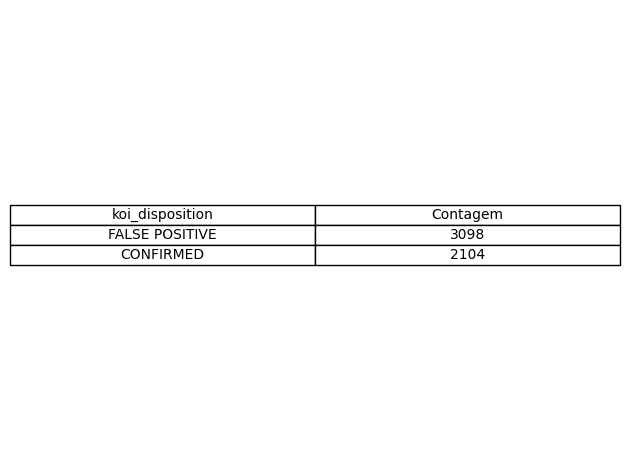

In [16]:
#Contagem de quantos CONFIRMED E FALSE POSITIVE tem NO DF

contagens = df.koi_disposition.value_counts()

# Criando a figura e o eixo
fig, ax = plt.subplots()

# Ocultando o eixo (opcional)
ax.axis('off')
ax.axis('tight')

# Convertendo para DataFrame para criar a tabela
table_data = contagens.reset_index()
table_data.columns = ['koi_disposition', 'Contagem']

# Criando a tabela
ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Ajustando o layout
fig.tight_layout()

# Exibindo a tabela
plt.show()

<h1>Análise de Modelos de Classificação</h1>

In [17]:
naive_bayes_experiment(X, Y, kf)
 

0.9166

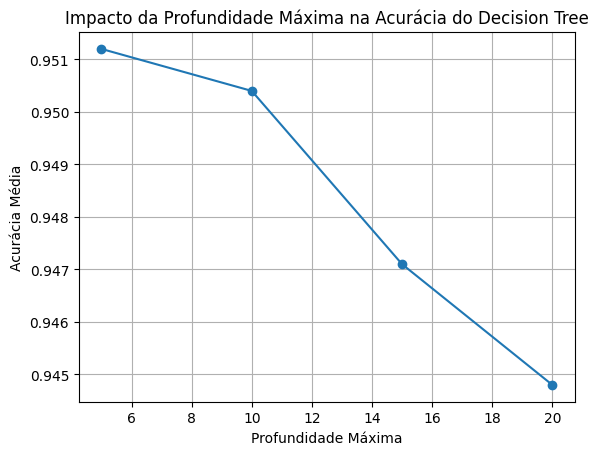

In [18]:
decision_tree_experiment(X, Y, kf)
   

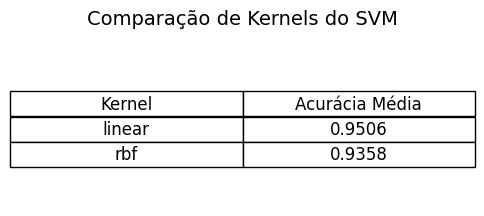

In [19]:
svm_experiment(X, Y, kf)
   

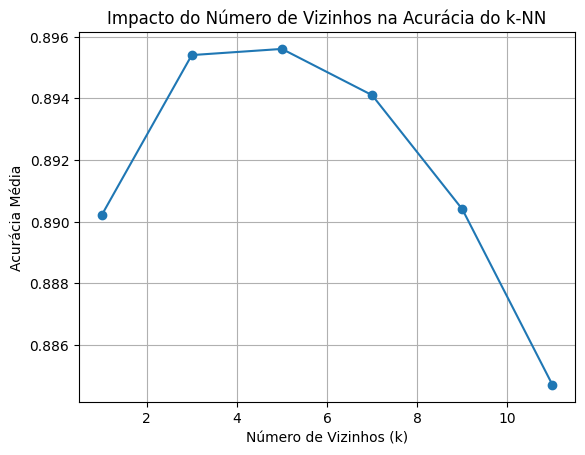

In [20]:
knn_experiment(X, Y, kf)

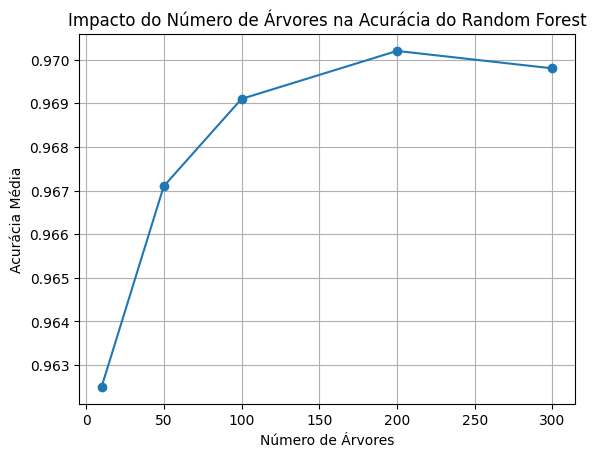

In [21]:
random_forest_experiment(X, Y, kf)

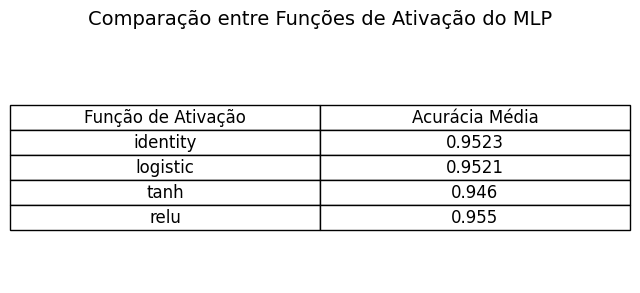

In [22]:
mlp_experiment(X, Y, kf)

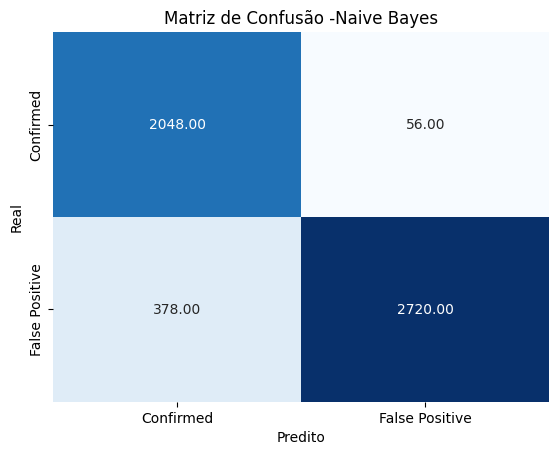

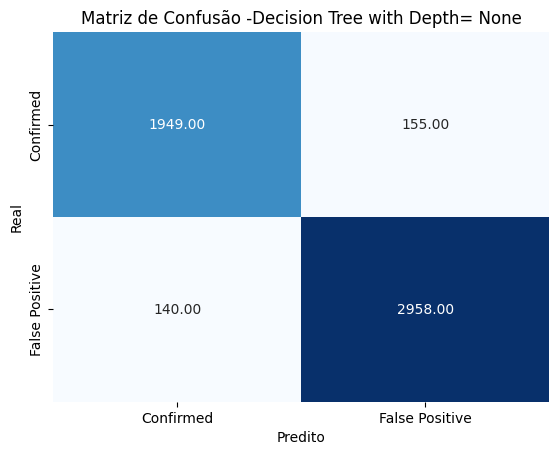

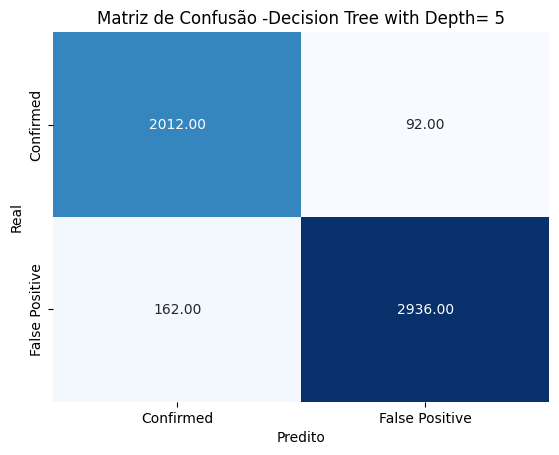

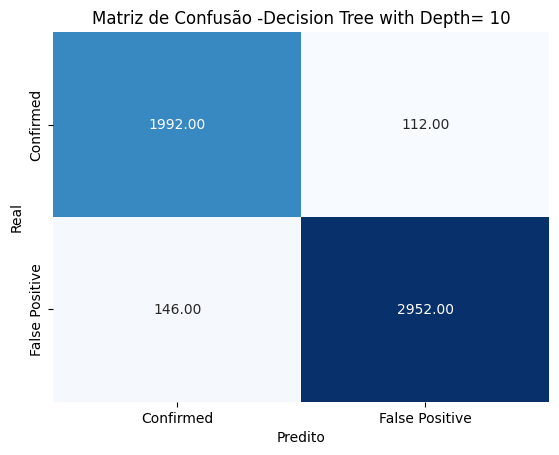

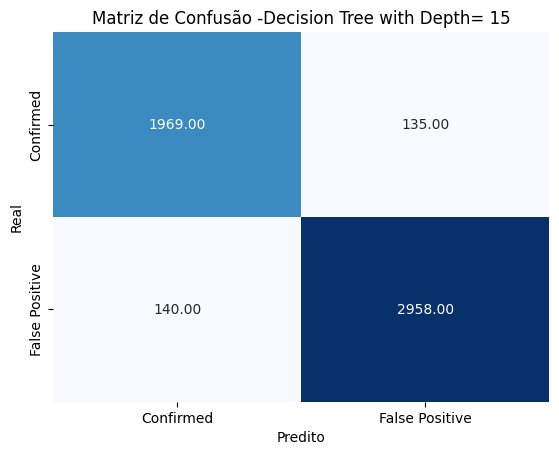

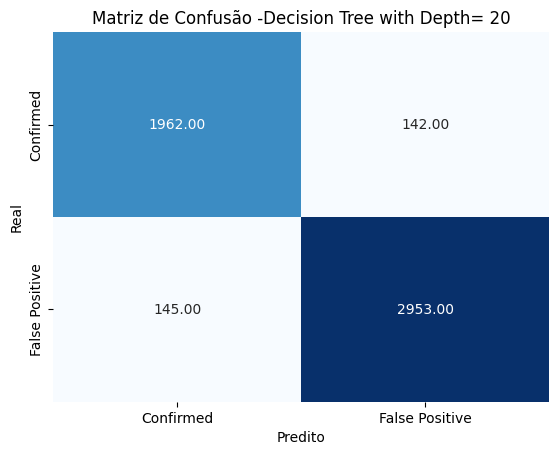

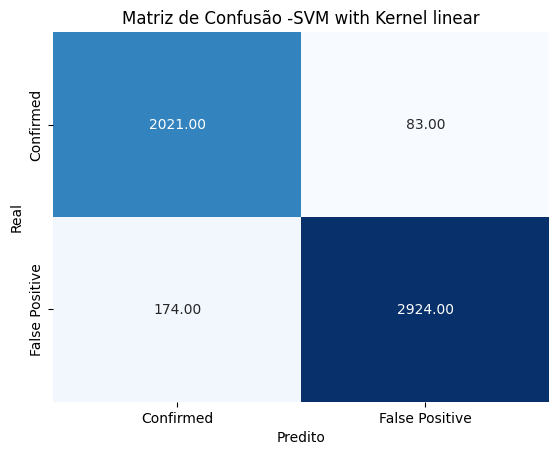

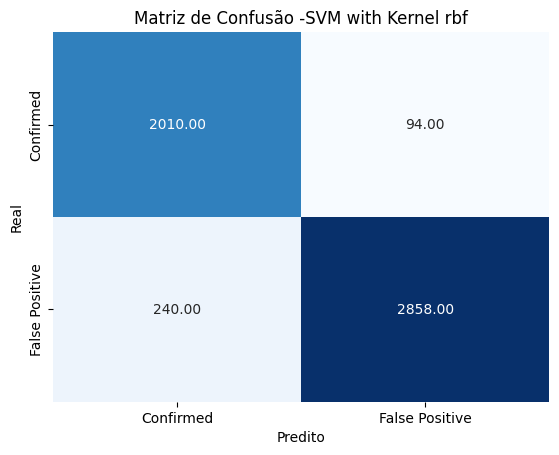

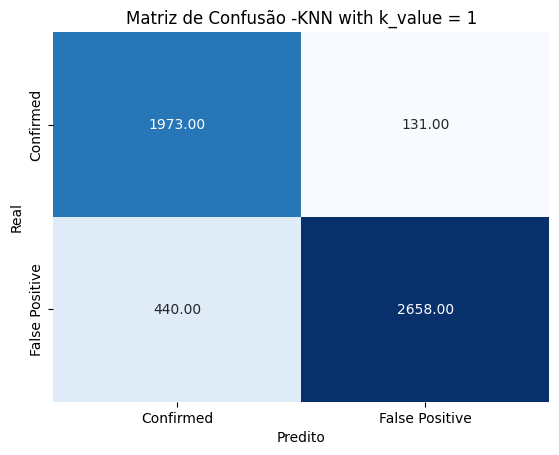

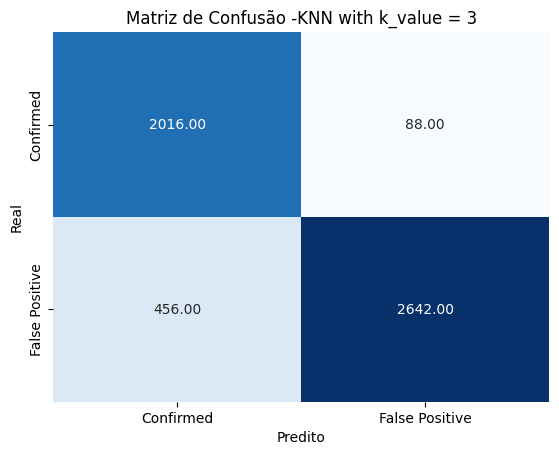

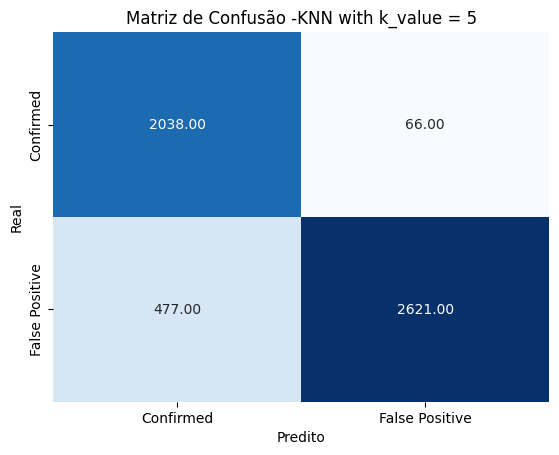

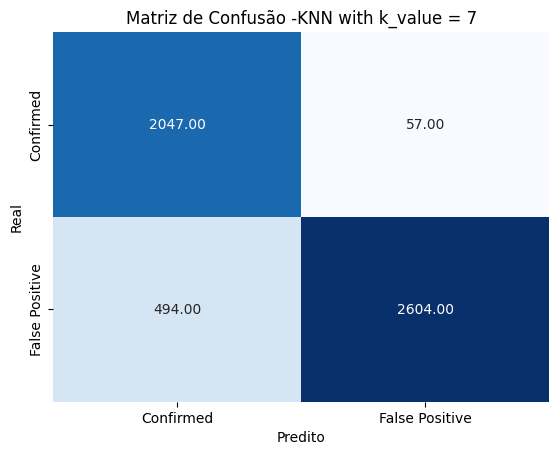

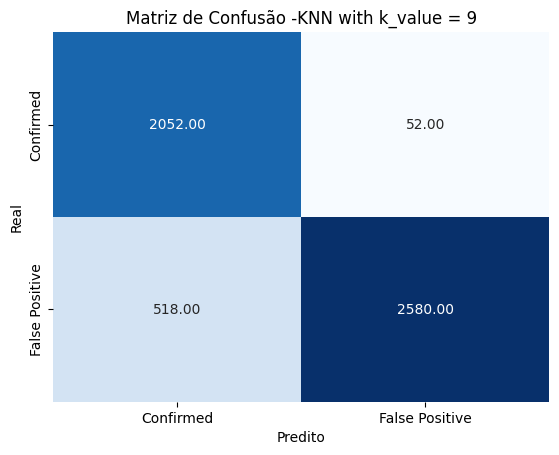

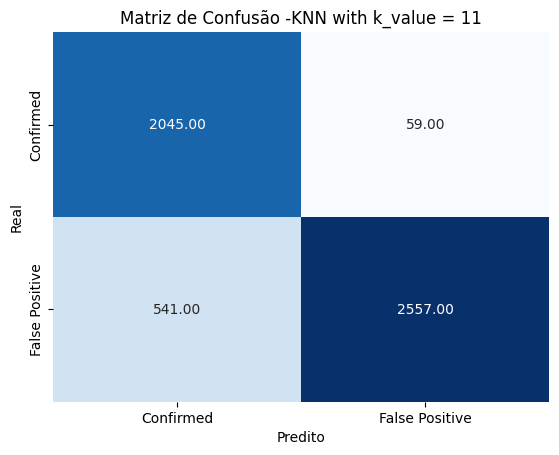

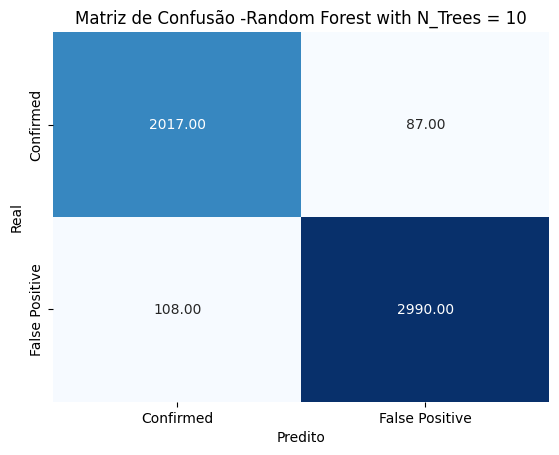

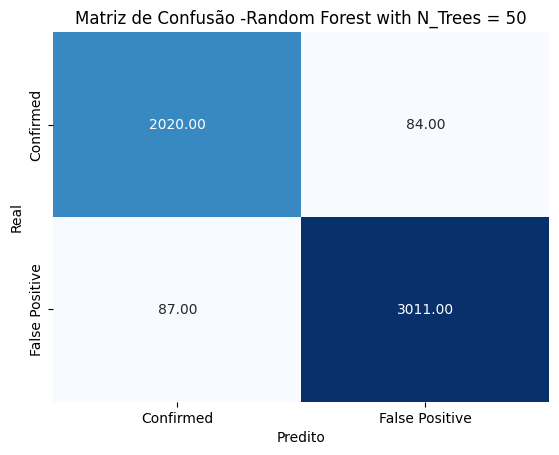

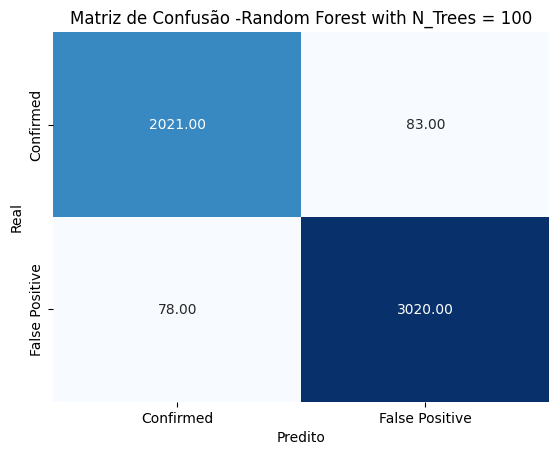

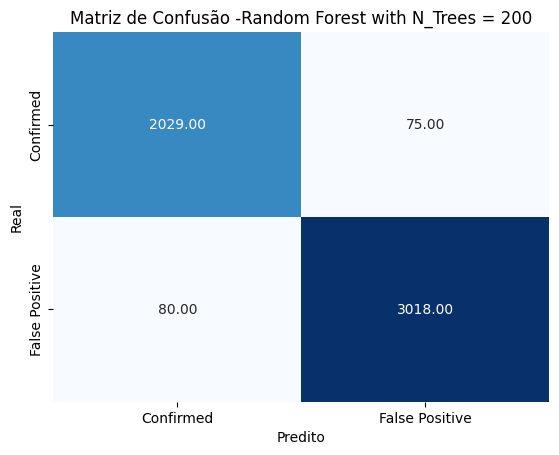

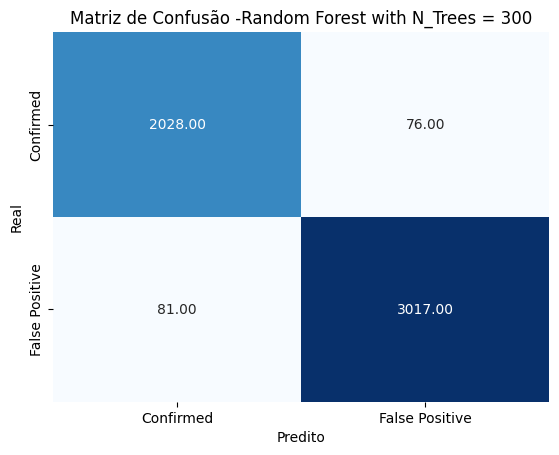

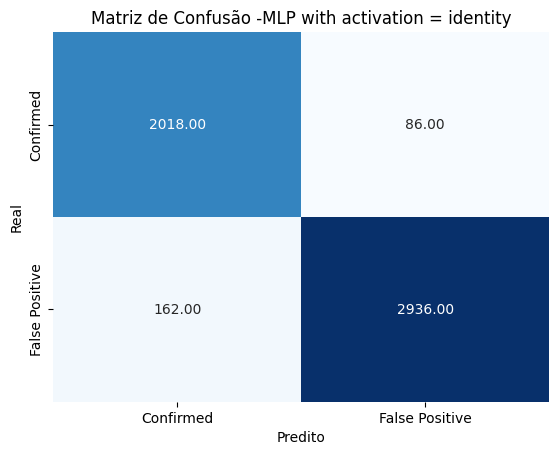

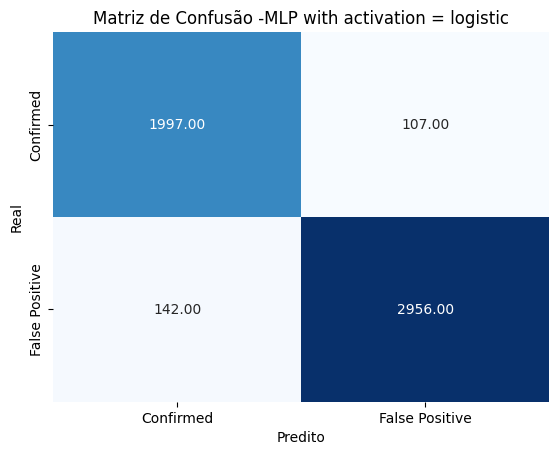

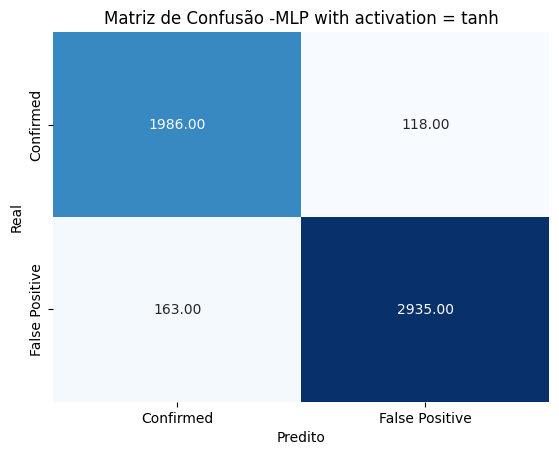

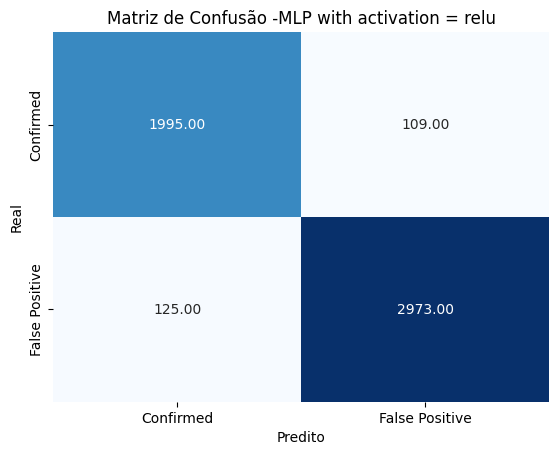

In [23]:
plot_all_confusion_matrix()

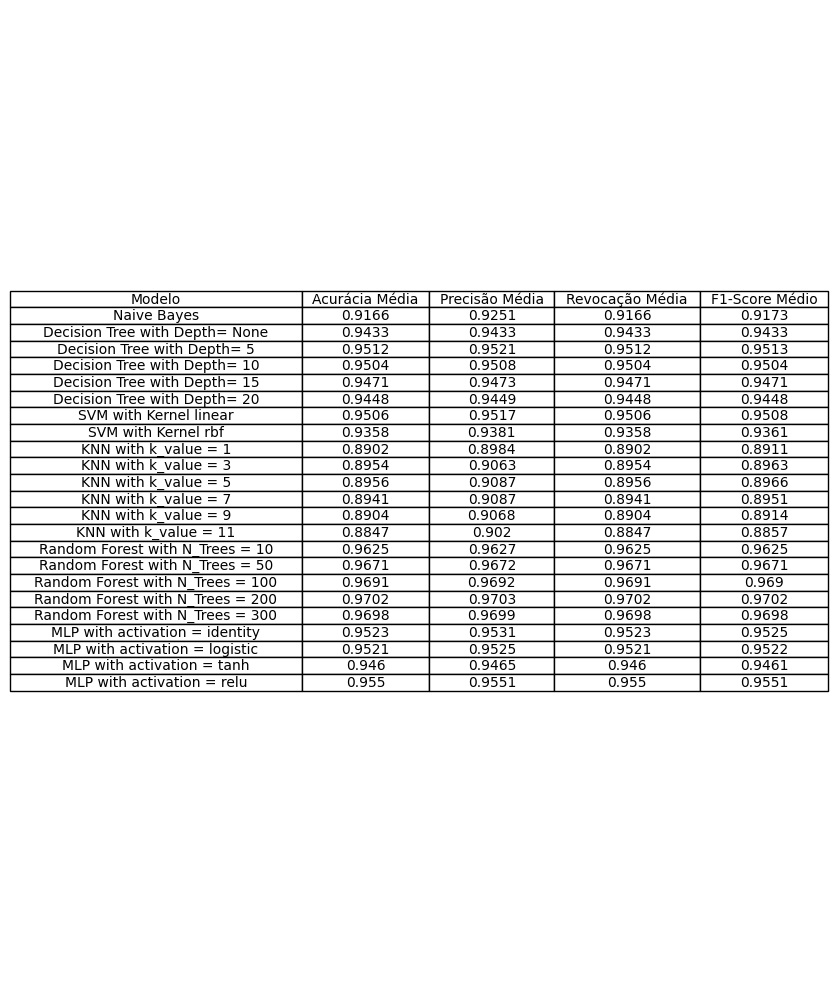

In [24]:
plotarAllMetrics()